# 标准化

## sc.pp.normalize_total标准化

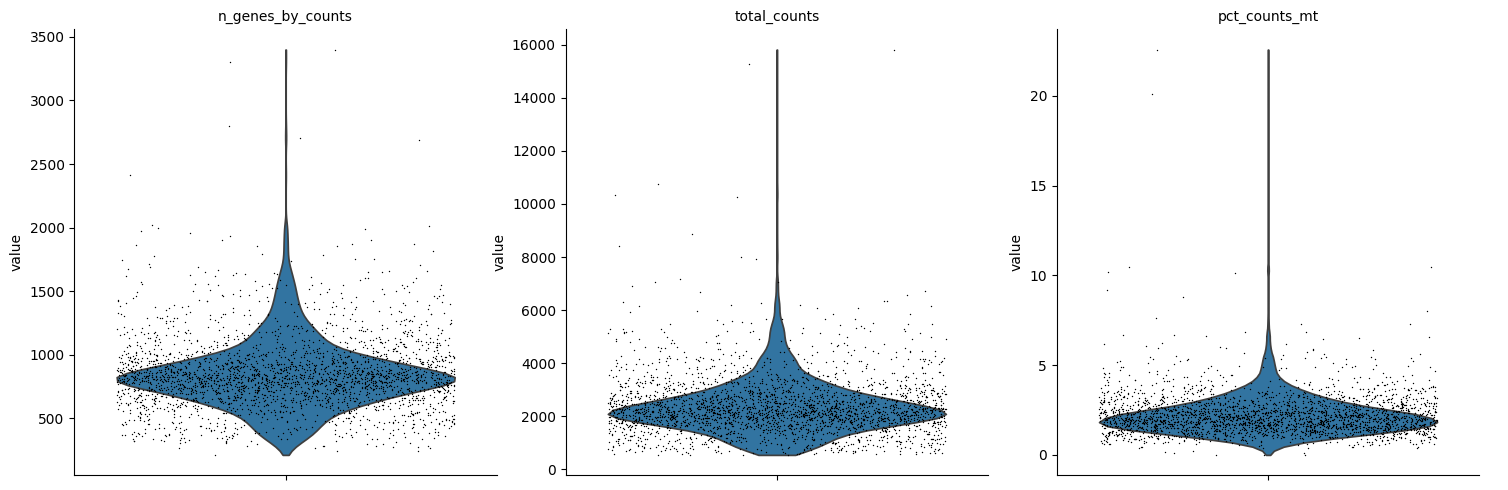

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

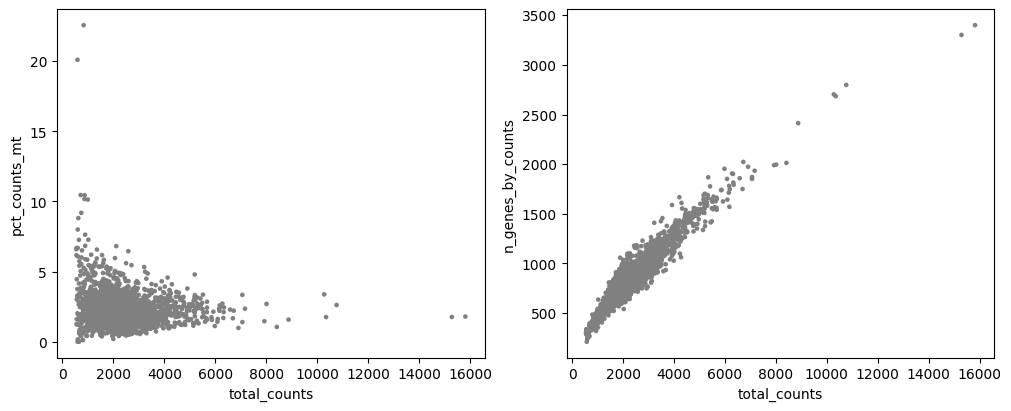

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc.pp.filter_cells(adata, min_genes=200)  # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1]);

adata = adata[
    (adata.obs.n_genes_by_counts < 2500) & (adata.obs.n_genes_by_counts > 200) & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

adata

In [ ]:
np.sum(adata.X, axis=1)

In [ ]:
# breakpoint()
sc.pp.normalize_total(adata, target_sum=1e4)

In [ ]:
np.sum(adata.X, axis=1)

In [ ]:
adata.to_df()

### 来自于sc.pp.normalize_total测试数据

In [ ]:
import numpy as np
from anndata import AnnData
import scanpy as sc

In [ ]:
arr = np.array(
    [
        [3, 3, 3, 6, 6],
        [1, 1, 1, 2, 2],
        [1, 22, 1, 2, 2],
    ],
    dtype="float32",
)
adata = AnnData(arr)

In [ ]:
sc.pp.normalize_total(adata, target_sum=1, inplace=True)
adata

In [ ]:
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True, max_fraction=0.2, inplace=False)['X']

##### 源码解析

对每一个细胞的计数进行标准化。

对于每一个细胞：

- 标准化值 = 单个基因的计数 / 细胞总的计数 * 目标值

先计算单个细胞总的计数，再用该细胞每个基因的计数去除，再乘以一个目标数，如果目标数是1百万（1e6），则是 CPM 标准化。

问题，单细胞标准化为什么不考虑基因长度，而只是考虑细胞总的计数。

如果细胞内某些基因的表达量过高，可以将其排除在细胞总计数之外。

一个细胞，类似于bulk的一个样本，因此标准化时以细胞为单位进行标准化。

一个细胞，是一个反应体系，每个细胞所测得的reads数不同，因此要按细胞进行标准化。

In [ ]:
def normalize_total(  # noqa: PLR0912
    adata: AnnData,
    *,
    target_sum: float | None = None,
    exclude_highly_expressed: bool = False,
    max_fraction: float = 0.05,
    key_added: str | None = None,
    layer: str | None = None,
    inplace: bool = True,
    copy: bool = False,
) -> AnnData | dict[str, np.ndarray] | None:
    """Normalize counts per cell.

    Normalize each cell by total counts over all genes,
    so that every cell has the same total count after normalization.
    If choosing `target_sum=1e6`, this is CPM normalization.

    If `exclude_highly_expressed=True`, very highly expressed genes are excluded
    from the computation of the normalization factor (size factor) for each
    cell. This is meaningful as these can strongly influence the resulting
    normalized values for all other genes :cite:p:`Weinreb2017`.

    Similar functions are used, for example, by Seurat :cite:p:`Satija2015`, Cell Ranger
    :cite:p:`Zheng2017` or SPRING :cite:p:`Weinreb2017`.
    """

# 求对数log1p



In [ ]:
adata.X.data

In [ ]:
sc.pp.log1p(adata)

In [ ]:
adata.X.data

In [ ]:

np.log1p(adata.X.data)

In [ ]:
np.log1p(15.120967)

In [ ]:
adata.to_df()

##### 源码解析

调用链：
- log1p_anndata
    - `log1p(x = adata.X)`
- log1p_sparce
    - `log1p(x = adata.X.data)`
- log1p_array
    - `np.log1p(x = adata.X.data, out=adata.X.data)`

最终会调用 `np.log1p(x, out=x)` 计算每一个单元格的值。

In [ ]:
@renamed_arg("X", "data", pos_0=True)
@singledispatch
def log1p(
    data: AnnData | np.ndarray | CSBase,
    *,
    base: Number | None = None,
    copy: bool = False,
    chunked: bool | None = None,
    chunk_size: int | None = None,
    layer: str | None = None,
    obsm: str | None = None,
) -> AnnData | np.ndarray | CSBase | None:
    _check_array_function_arguments(
        chunked=chunked, chunk_size=chunk_size, layer=layer, obsm=obsm
    )
    return log1p_array(data, copy=copy, base=base)

@log1p.register(AnnData)
def log1p_anndata(
    adata: AnnData,
    *,
    base: Number | None = None,
    copy: bool = False,
    chunked: bool = False,
    chunk_size: int | None = None,
    layer: str | None = None,
    obsm: str | None = None,
) -> AnnData | None:
    if "log1p" in adata.uns:
        logg.warning("adata.X seems to be already log-transformed.")

    adata = adata.copy() if copy else adata
    view_to_actual(adata)

    if chunked:
        if (layer is not None) or (obsm is not None):
            msg = (
                "Currently cannot perform chunked operations on arrays not stored in X."
            )
            raise NotImplementedError(msg)
        if adata.isbacked and adata.file._filemode != "r+":
            msg = "log1p is not implemented for backed AnnData with backed mode not r+"
            raise NotImplementedError(msg)
        for chunk, start, end in adata.chunked_X(chunk_size):
            adata.X[start:end] = log1p(chunk, base=base, copy=False)
    else:
        x = _get_obs_rep(adata, layer=layer, obsm=obsm)
        if is_backed_type(x):
            msg = f"log1p is not implemented for matrices of type {type(x)}"
            if layer is not None:
                msg = f"{msg} from layers"
                raise NotImplementedError(msg)
            msg = f"{msg} without `chunked=True`"
            raise NotImplementedError(msg)

        # x = adata.X
        x = log1p(x, copy=False, base=base)
        _set_obs_rep(adata, x, layer=layer, obsm=obsm)

    adata.uns["log1p"] = {"base": base}
    if copy:
        return adata

# 调用：
@_register_union(log1p, CSBase)
def log1p_sparse(x: CSBase, *, base: Number | None = None, copy: bool = False):
    x = check_array(
        x, accept_sparse=("csr", "csc"), dtype=(np.float64, np.float32), copy=copy
    )
    x.data = log1p(x.data, copy=False, base=base)
    return x

# 调用：
@log1p.register(np.ndarray)
def log1p_array(x: np.ndarray, *, base: Number | None = None, copy: bool = False):
    # Can force arrays to be np.ndarrays, but would be useful to not
    # X = check_array(X, dtype=(np.float64, np.float32), ensure_2d=False, copy=copy)
    if copy:
        x = x.astype(float) if not np.issubdtype(x.dtype, np.floating) else x.copy()
    elif not (np.issubdtype(x.dtype, np.floating) or np.issubdtype(x.dtype, complex)):
        x = x.astype(float)

    # 最终计算位置。x = adata.X.data
    np.log1p(x, out=x)
    if base is not None:
        np.divide(x, np.log(base), out=x)
    return x

##### 背景知识

`log1p(x) = log(x+1)`

In [ ]:
np.log(np.e)

In [ ]:
np.log(np.e+1)

In [ ]:
np.log1p(np.e)